# Modeling Food Serving Sizes Through Nutrition Profiles

### Notebook 2 - EDA

## Table of Contents

1. [Importing Packages](#Importing-Packages)
2. [Reading Data](#Reading-Data)
3. [EDA/Visualization](#EDA/Visualization)
    1. [Bar Charts](#Bar-Charts)
    2. [Distributions](#Distributions)
    3. [Scatterplots](#Scatterplots)
    4. [Vectorizing Ingredients](#Vectorizing-Ingredients)
4. [Sources](#Sources)

## Importing Packages

In [1]:
# general tools/visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap

# imports for NLP
import regex as re
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import RegexpTokenizer

# making the magic happen for plots
%matplotlib inline

# setting options for better viewing
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 200)
pd.set_option("display.max_colwidth", 100)

## Reading Data

From this point forward, we are going to utilize the combined and cleaned dataset from the end of the previous notebook.

In [2]:
foods = pd.read_csv("../datasets/clean_foods_df.csv")

In [3]:
foods.head()

,fdc_id,brand_owner,branded_food_category,description,ingredients,serving_size,household_serving_fulltext,energy,fat_total,fat_sat,fat_trans,chol,protein,carbs,fiber,sugars,sodium
0,356425,"G. T. Japan, Inc.",Ice Cream & Frozen Yogurt,MOCHI ICE CREAM BONBONS,"ICE CREAM INGREDIENTS: MILK, CREAM, SUGAR, STRAWBERRIES (STRAWBERRIES, SUGAR), CORN SYRUP SOLIDS...",40.0,1 PIECE,200.0,6.25,3.75,0.0,25.0,2.5,35.00,0.0,30.00,75.0
1,356426,FRESH & EASY,"Ketchup, Mustard, BBQ & Cheese Sauce",CHIPOTLE BARBECUE SAUCE,"WATER, SUGAR, TOMATO PASTE, MOLASSES, DISTILLED VINEGAR, CONTAINS 2% OR LESS OF: CORN STARCH, SA...",37.0,2 Tbsp,162.0,0.00,0.00,0.0,0.0,0.0,43.24,0.0,37.84,703.0
2,356427,FRESH & EASY,"Ketchup, Mustard, BBQ & Cheese Sauce",HOT & SPICY BARBECUE SAUCE,"SUGAR, WATER, DISTILLED VINEGAR, TOMATO PASTE, MOLASSES, MODIFIED CORN STARCH, SALT, PINEAPPLE J...",34.0,2 Tbsp,176.0,0.00,0.00,0.0,0.0,0.0,41.18,0.0,35.29,676.0
3,356428,FRESH & EASY,"Ketchup, Mustard, BBQ & Cheese Sauce",BARBECUE SAUCE,"TOMATO PUREE (WATER, TOMATO PASTE), SUGAR, DISTILLED VINEGAR, MOLASSES, WATER, MODIFIED CORN STA...",35.0,2 Tbsp,143.0,0.00,0.00,0.0,0.0,0.0,34.29,0.0,28.57,971.0
4,356429,FRESH & EASY,"Ketchup, Mustard, BBQ & Cheese Sauce",BARBECUE SAUCE,"SUGAR, DISTILLED VINEGAR, WATER, TOMATO PASTE, HONEY, MOLASSES, MODIFIED CORN STARCH, SALT, CONT...",37.0,2 Tbsp,189.0,0.00,0.00,0.0,0.0,0.0,45.95,0.0,43.24,757.0


## EDA/Visualization

To help with some of the visualization in the EDA step, it would be helpful to have a function for creating common charts.

In [4]:
# making func for top 10 of whatever counts we need
def top_10(df, col, title, x_lab, y_lab=None, x_tick=None):
    plt.figure(figsize=(10, 8))
    df[col].value_counts(ascending=True).tail(10).plot(kind="barh")
    plt.title(title, size=20)
    plt.xlabel(x_lab, size=15)
    plt.ylabel(y_lab, size=15)
    plt.xticks(x_tick)

In [5]:
# making func for scatterplots
def scatter_plot(df, x_col, y_col, title, x_lab=None, y_lab=None, x_tick=None, y_tick=None):
    plt.figure(figsize=(10, 7))
    plt.scatter(df[x_col], df[y_col])
    plt.title(title, size=20)
    plt.xlabel(x_lab, size=15)
    plt.ylabel(y_lab, size=15)
    plt.xticks(x_tick)
    plt.yticks(y_tick)

In [6]:
# making func for dist plots
def dist_plot(df, col, title, x_lab, x_tick=None, bins=None):
    plt.figure(figsize=(9, 6))
    plt.hist(df[col], bins=bins)
    plt.title(title, size=20)
    plt.xlabel(x_lab, size=15)
    plt.ylabel("Frequency", size=15)
    plt.xticks(x_tick)

One of the first things we can look at in terms of visualizing out data is the see if any of the columns already have a strong correlation with our target of `serving_size`, or even with each other. We can use Seaborn's heatmap 

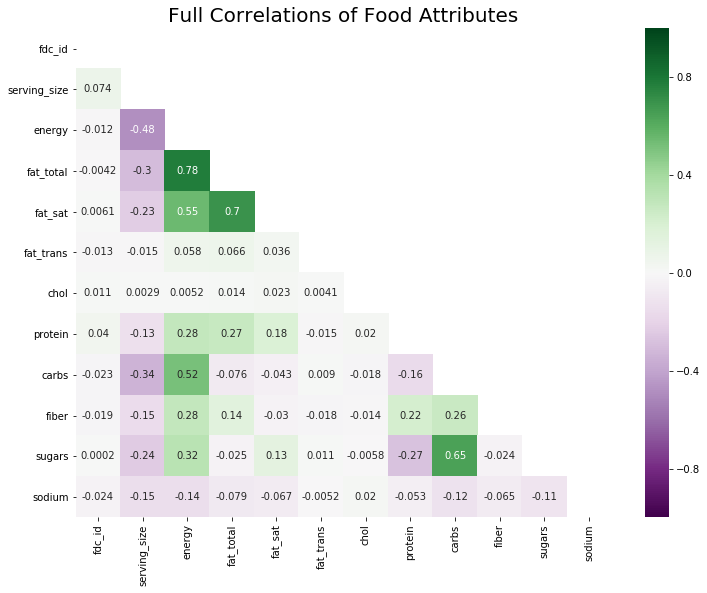

In [7]:
# making corrs
corr = foods.corr()

# making mask
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# making heatmap of correlations
plt.figure(figsize=(12, 9))
sns.heatmap(corr, vmax=1, vmin=-1, cmap="PRGn", annot=True, mask=mask)
plt.title("Full Correlations of Food Attributes", size=20);

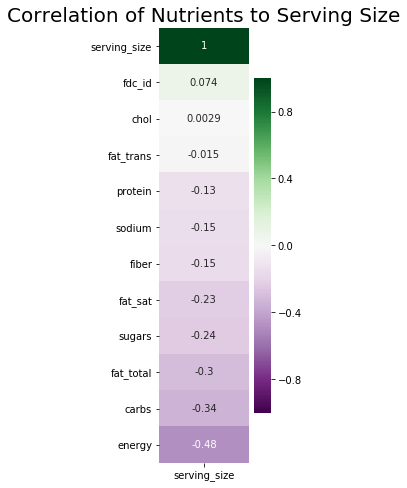

In [8]:
# making heatmap of correlations
plt.figure(figsize=(2, 8))
sns.heatmap(foods.corr()[["serving_size"]].sort_values(by="serving_size", ascending=False),
            vmax=1,vmin=-1,cmap="PRGn",annot=True)
plt.title("Correlation of Nutrients to Serving Size", size=20);

None of the current nutrition features apear to be very highly correlated with the serving size target, though most have a slightly negative correlation. The best single indicator seems to be energy, with a negative correlation of -0.48. The direction of this correlation does appear to make sense, as foods with very high caloric densities probably have smaller serving sizes to keep the calories-per-serving within a reasonable range.

There is, however, some higher correlation between some of the features, particularly between total fat and saturated fat, and between carbohydrates and sugar. This correlation is expected, as in both cases the latter is a subset of the former, so there should be a connection between them. We also see correlations between fats and carbohyrates with energy. This also is somewhat expected, as we know that these two macronutrients are part of the main sources of calories for any food. However, as the sub-categories of these macronutrients are not necessarily the full breakdown of those macronutrients, we cannot determine that these columns are showing multicolinearity.

### Bar Charts

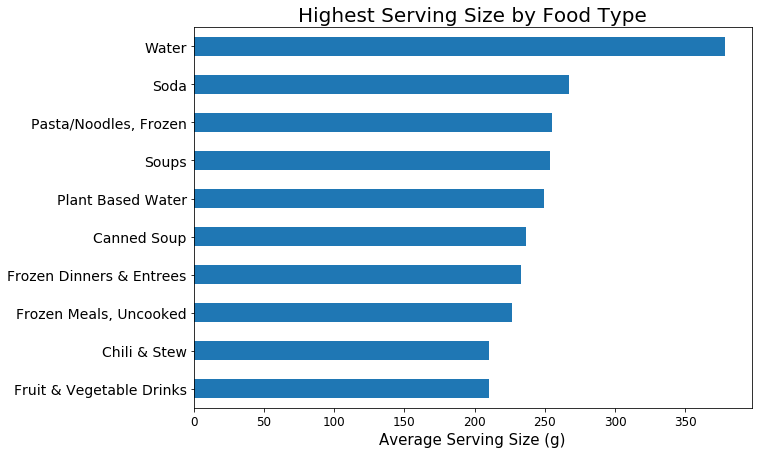

In [9]:
# making custom y-tick labels for clarity
y_ticks = ["Water", "Soda", "Pasta/Noodles, Frozen", "Soups", "Plant Based Water", "Canned Soup",
          "Frozen Dinners & Entrees", "Frozen Meals, Uncooked", "Chili & Stew", "Fruit & Vegetable Drinks"]
y_ticks = [ '\n'.join(wrap(tick, 30)) for tick in y_ticks]

# making large figure
plt.figure(figsize=(10, 7))

foods.groupby("branded_food_category")["serving_size"].mean().sort_values().tail(10).plot(kind="barh")
plt.title("Highest Serving Size by Food Type", size=20)
plt.xlabel("Average Serving Size (g)", size=15)
plt.xticks(size=12)
plt.ylabel(None)
plt.yticks(range(10), y_ticks[::-1], size=14);

Here we see the which food categories have the highest serving sizes, and there is clearly a common theme. Four of the ten entries are water or another type of beverage. Liquids tend to be fairly dense, so it would make sense that these types of food products woul dhave the highest average weights. Frozen meals also make sense to be on this list, since they typically include multiple types of foods, intending to be a full meal. This would expectedly be a higher weight than any one food on its own (like pasta or sauce by themselves).

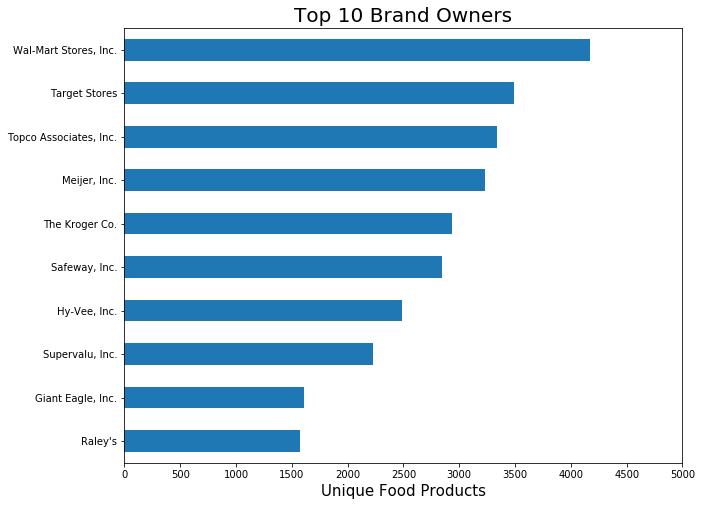

In [10]:
# plotting number of food products per owner
top_10(foods,
       "brand_owner",
       title="Top 10 Brand Owners",
       x_lab="Unique Food Products",
      x_tick=range(0, 5001, 500))

We see from this chart that the top brand owners are large national chains of supermarkets. This is not unexpected because supermarket chains typically have their own brands of foods, and these can range the entire variety of food products that are offered within the store. As Fortune recently named Wal-Mart the largest company in the world by revenue<sup>(1)</sup>. Concentrating within these companies, there may be some visisble trends in serving sizes.

Text(0.5, 0, 'Average Serving Size (g)')

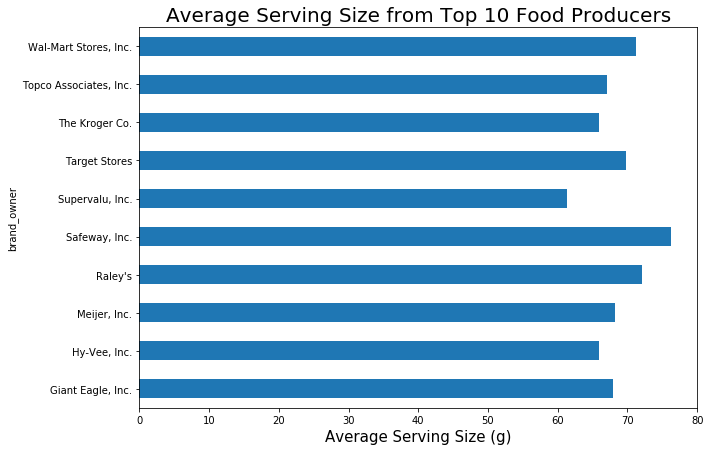

In [11]:
# making a list of the top 10 brand owners
top_brands = foods["brand_owner"].value_counts(ascending=False).head(10).index

# isolating top companies
top_companies = foods[foods["brand_owner"].isin(top_brands)]

# finding the average serv_size of their products
plt.figure(figsize=(10, 7))
foods[foods["brand_owner"].isin(top_brands)].groupby("brand_owner")["serving_size"].mean().plot(kind="barh")
plt.title("Average Serving Size from Top 10 Food Producers", size=20)
plt.xlabel("Average Serving Size (g)", size=15)

With an average serving size of around 64g, we see a similar numbers in the top 10 brand producers, with most of the serving size averages being around the overall mean. The highest of this group seems to be Safeway, with an average of nearly 80g per serving, and the lowest is Supervalu, with close to 60g. Alone, this does not seem to tell us much, but there might be more information as we look into what kinds of foods are in this dataset.

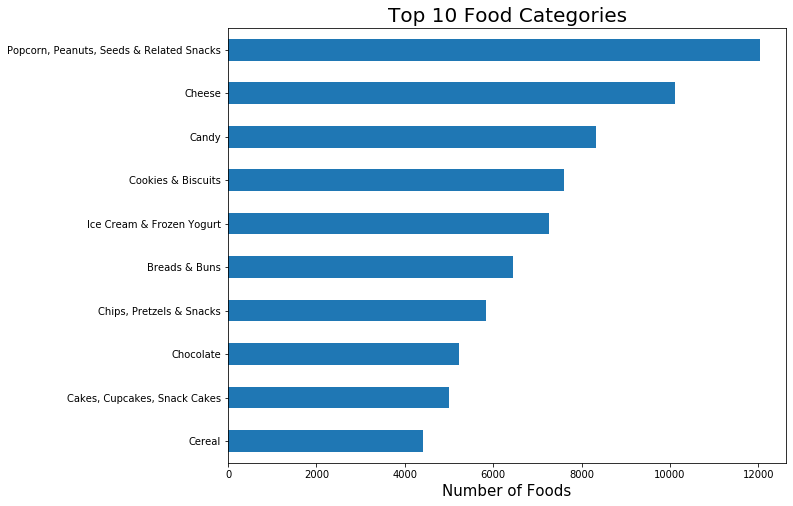

In [12]:
top_10(foods,
       col="branded_food_category",
       title="Top 10 Food Categories",
       x_lab="Number of Foods")

We can see from this chart that most of the food items are snacks and desserts. Many of these items are most likely owned by those top ten companies from the previous chart. 

We can make something of an intersection between this chart and the previous one to see if there is a specific trend in the food categories of Safeway's products.

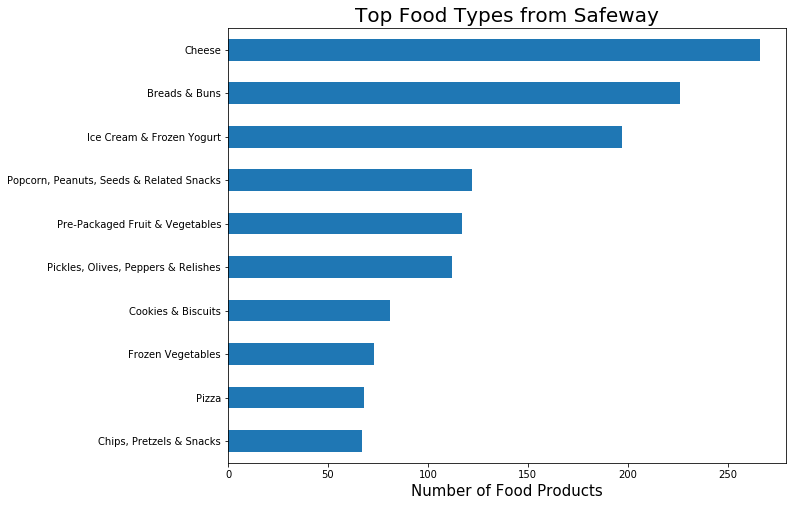

In [13]:
top_10(foods[foods["brand_owner"] == "Safeway, Inc."] ,
      "branded_food_category",
      title="Top Food Types from Safeway",
      x_lab="Number of Food Products")

We can see here that the top product types from Safeway are most likely high in calories, with categories like cheese, and ice cream, which does line up with the overall most common food types. It is actually somewhat counterintuitive that these would be giving high serving sizes, so this might not be telling the whole story. We are going to see what the highest serving sizes are within Safeway's products.

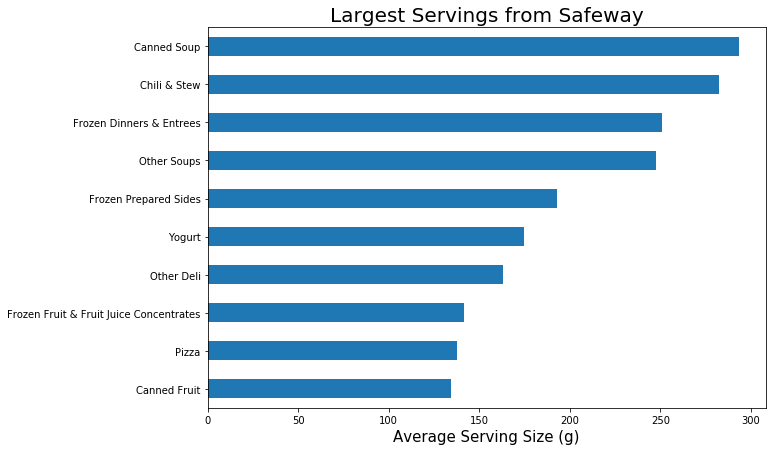

In [14]:
# making var of just the top food types from safeway 
safeway_top_servings = foods[foods["brand_owner"] == "Safeway, Inc."].groupby(
    "branded_food_category")["serving_size"].mean().sort_values(ascending=True).tail(10)

# plotting top 10
plt.figure(figsize=(10, 7))
safeway_top_servings.plot(kind="barh")
plt.title("Largest Servings from Safeway", size=20)
plt.xlabel("Average Serving Size (g)", size=15)
plt.ylabel(None);

Now we can see the foods from Safeway that actually have high serving sizes. Soups and frozen dinners top the chart, which makes more sense than the cheese and breads from the previous chart. These categories actually line up with the chart of the highest serving sizes from the overall dataset, with many soups and frozen meals on the list. This may be an indication that Safeway has as higher ratio of these types of products than some of the other companies on the top ten list, skewing the average serving size.

### Distributions

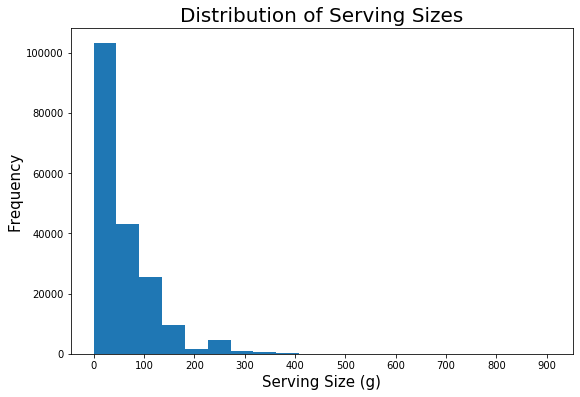

In [15]:
dist_plot(foods,
          col="serving_size",
          title="Distribution of Serving Sizes",
          x_lab="Serving Size (g)",
          x_tick=range(0, 901, 100),
          bins=20)

The serving sizes of this dataset are heavily skewed to the lower end, with the vast majority of foods having servings sizes between 0 and 50 grams. This could be from many factors, including having a high caloric density. We attempt to determine if there is any clear trend between the nutrional content and serving size by analyzing these features as well.

In terms of predicting this value, it may be helpful to our model to have this column transformed as a logarithmic value.

In [16]:
# adding col for log-servings
foods["log_serv"] = np.log(foods["serving_size"])

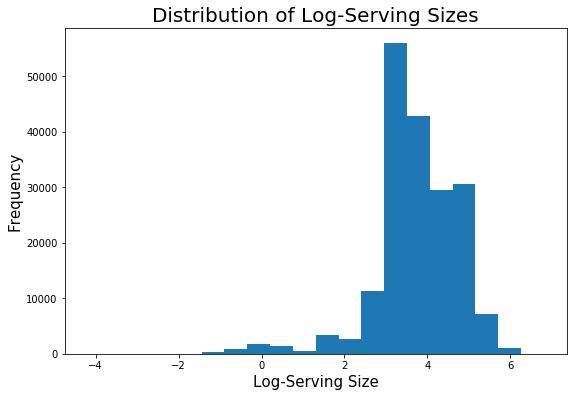

In [17]:
dist_plot(foods,
          col="log_serv",
         title="Distribution of Log-Serving Sizes",
         x_lab="Log-Serving Size",
         bins=20)

While we now have a left tailed distribution, it is much more normal than the original histogram above. This should prove to be an effective transformation of the target.

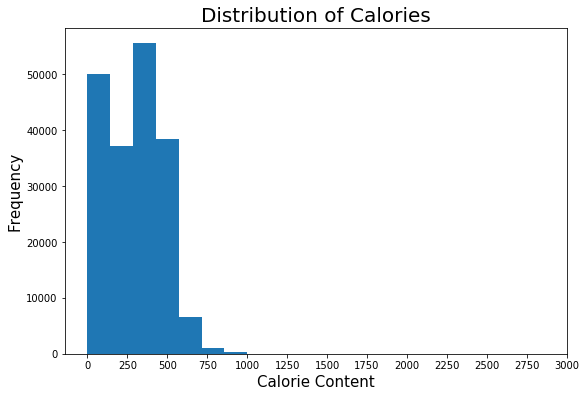

In [18]:
dist_plot(foods,
         col="energy",
         title="Distribution of Calories",
         x_lab="Calorie Content",
         bins=20,
         x_tick=range(0, 3001, 250))

Here we see a wide distribution of calorie contents, mostly occuring below 500 calories. This distribution is a bit wider than the serving sizes, showing that there is not one specific trend in terms of caloric content of a food, and it will greatly depend on the full context of that food product.

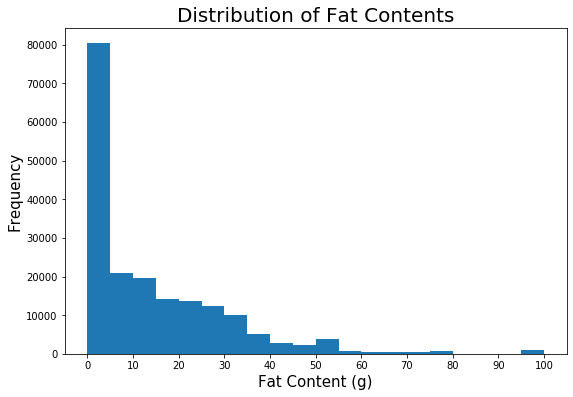

In [19]:
dist_plot(foods,
         col="fat_total",
         title="Distribution of Fat Contents",
         x_lab="Fat Content (g)",
         bins=20,
         x_tick=range(0, 101, 10))

This is an interesting chart, showing that by a huge margin, most of the food prodcuts in this database have no fat in them. Given what we saw in terms of the top categories of our foods, mostly being snacks and desserts, it is surprising that by far the most common entry for fat content is 0. However, going down the list after this first entry, we see some very high fat contents showing up. We saw previously that the mean fat content for these foods is around 12g per 100g of food, and most of these are well above that average. For these foods, that fat content will probably have a high impact on the serving size, as fats give a large amount of calories, and 

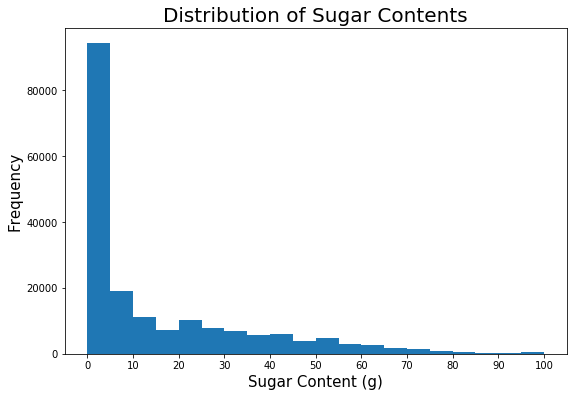

In [20]:
dist_plot(foods,
         col="sugars",
         x_lab="Sugar Content (g)",
         title="Distribution of Sugar Contents",
         x_tick=range(0, 101, 10),
         bins=20)

As with the fat contents, the wide majority of food products have little to no sugar in them. 

### Scatterplots

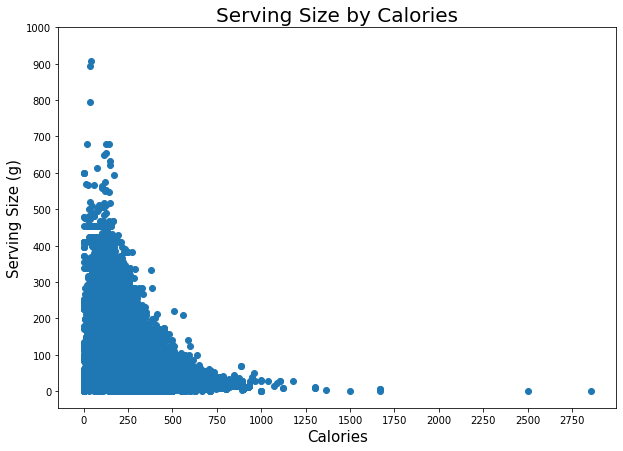

In [21]:
scatter_plot(df=foods,
             y_col="serving_size",
             x_col="energy",
             title="Serving Size by Calories",
             y_lab="Serving Size (g)",
             x_lab="Calories",
             x_tick=range(0, 2800, 250),
            y_tick=range(0, 1001, 100))

This plot shows the relationship between calories and serving size. With almost all of the points occurring in the lower left corner, there is not a lot fo information to gain in the lower calorie range. However, we can tell that as calories increase, there is a very sharp decline in the serving size. Some of the highest calorie foods, which we previously discovered include spice mixtures, have extremely small serving sizes.

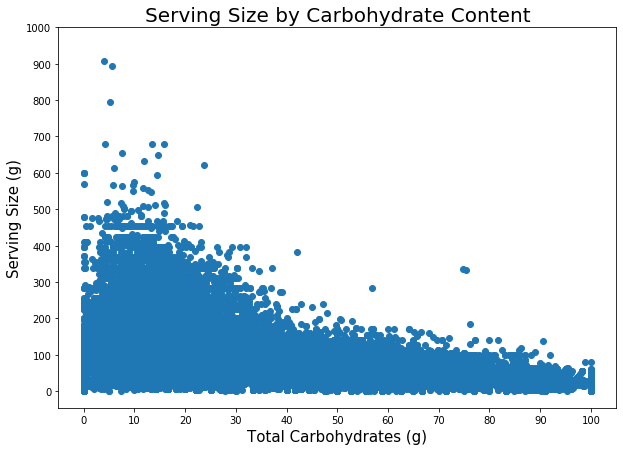

In [22]:
scatter_plot(df=foods,
             x_col="carbs",
             y_col="serving_size",
             title="Serving Size by Carbohydrate Content",
             x_lab="Total Carbohydrates (g)",
             y_lab="Serving Size (g)",
             x_tick=range(0, 101, 10),
             y_tick=range(0, 1001, 100))

This chart shows that there is even less of a distinct trend of serving size when compared against carbohydrates. As we saw that most foods have serving sizes below 200g, we see the full range of carbohydrate contents being fairly dense in population. This means that just because a food has more carbohydrates, does not necessarily mean that it will have a smaller serving size. It is, however, still somewhat more likely that a food that is low in carbohydrates will have a higher serving size.

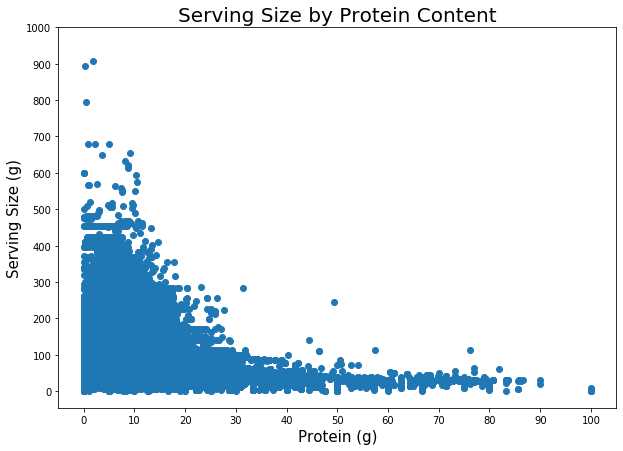

In [23]:
scatter_plot(df=foods,
             x_col="protein",
             y_col="serving_size",
             title="Serving Size by Protein Content",
             x_lab="Protein (g)",
             y_lab="Serving Size (g)",
             x_tick=range(0, 101, 10),
             y_tick=range(0, 1001, 100))

The chart of serving sizes against protein content looks similar the the calorie scatterplot above. Lower protein contents are far more likely to have a larger serving size, and that serving has a sharp decline as the protein content goes up. The highest protein contents are most likely raw sources of protein, like meats, which would typically have smaller serving sizes anyway.

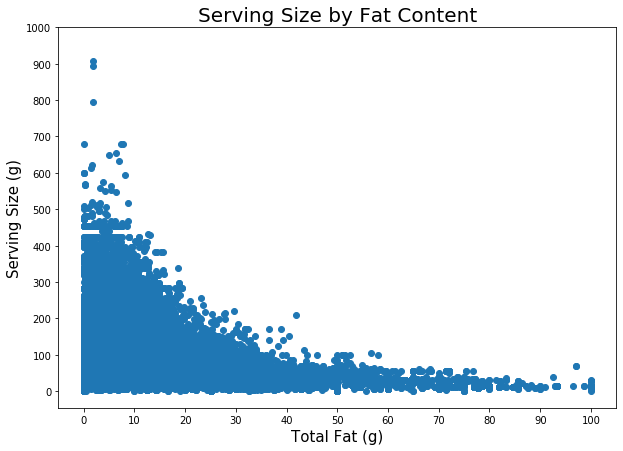

In [24]:
scatter_plot(df=foods,
             x_col="fat_total",
             y_col="serving_size",
             title="Serving Size by Fat Content",
             x_lab="Total Fat (g)",
             y_lab="Serving Size (g)",
             x_tick=range(0, 101, 10),
             y_tick=range(0, 1001, 100))

The scatterplot of the fat contents looks the most similar to the protein plot above, and again leaves us without having a lot of interpretation. It is somewhat surprising to see this plot not have a sharper drop-off in serving size, as fat contributes more calories than protein or carbohydrates, and we saw above how sharply calories will affect the serving size.

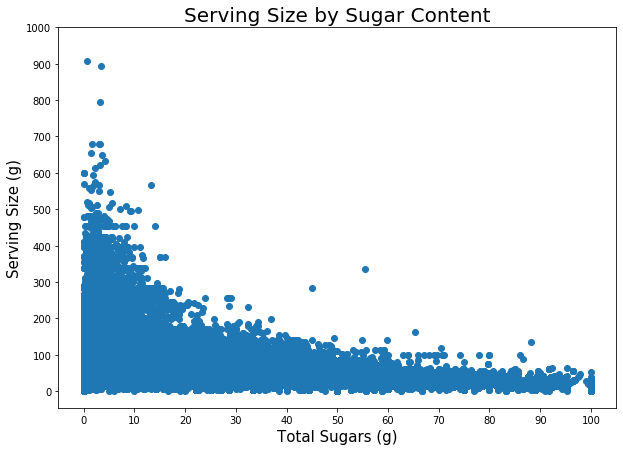

In [25]:
scatter_plot(df=foods,
             x_col="sugars",
             y_col="serving_size",
             title="Serving Size by Sugar Content",
             x_lab="Total Sugars (g)",
             y_lab="Serving Size (g)",
             x_tick=range(0, 101, 10),
             y_tick=range(0, 1001, 100))

As with the other plots above, there is a distinct pattern in the relationship between the amount of sugar in a food and the serving size of that food. 

Overall, it is difficult to find any clear trends between these core nutrient contents and the serving size. While it would be better if some of these had more linear relationships, we will have to see if our models can find useful ways of incorporating them to determine serving size.

### Vectorizing Ingredients

As ingredients lists have to meet strict legal regulations, they are already somewhat standardized. Therefore, we should need minimal processing when dealing with these entries. Since each ingrient is separated by a comma, we can simply separate on those commas, and vectorize the text in between them. Instances where ingredients are expanded or qualified with further text or ingredients wrapped in parentheses, it still makes sense to group them together as a single entry, as they should be consistently utilized across different foods.

Food products are many times made up of multiple sub-foods, and when making ingredient lists, the ingredients of those subfoods are also rquired to be listed. These sub-ingredient lists can become extremely complex, and were proving to be too much for our vectorizer to handle. Because of this, any sub-ingredient lists are going to be removed. In order to do this, we are going to create a function that utilizes regex to find parentheses, and remove any text within them. This will remove the sub-ingredient lists but leave the top-level food name as an ingredient in the original product.

In [26]:
# making func to remove sub-ings
def remove_parens(ings):
    # finding paren sections, subbing with blanks
    return re.sub(" ?\([^)]+\)", "", ings)

In [27]:
# removing parens entries
foods["ingredients"] = foods["ingredients"].apply(lambda x: remove_parens(x))

After this step, we want to remove any further punctuation, such as periods at the ends of the lists. We still want to keep commas, however, as we are going to utilize them in the next step.

In [28]:
# making func to remove non-comma punc, non alpha-num chars
def remove_punc(ings):
    # finding unwanted chars, subbing with blanks
    return re.sub(pattern="[^ ,a-zA-Z0-9\[\]]",
       repl= "",
       string=ings)

In [29]:
# removing unwanted punc
foods["ingredients"] = foods["ingredients"].apply(lambda x: remove_punc(x))

Now that we have formatted the ingredients to be a bit more simplified, we can vectorize, and present them in a dataframe. Since all of our ingredients are separated by commas, we can use that as the delimeter in the vectorizer.

In [30]:
# making func to split on commas
def cust_tokens(string):
    return string.split(sep=", ")  

Now using the custom comma separator, we can vectorize each of the distinct ingredients. As there are so many different ingredients across all of these food products, we are going to set a minimum document frequency in the vecotrizer. This will only keep ingredients that show up in at least 1% of all of the foods. We will also remove any stop words, as there sometimes are sentences or phrases within the lists, such as "Contains less than 2% of:", and removing the stop words will reduce any potential variations on these common phrases.

In [31]:
# instantiating vectorizer
cvec = CountVectorizer(tokenizer=cust_tokens, min_df=0.01, stop_words="english")

# fitting to ingredients col
ing_vec = cvec.fit_transform(foods["ingredients"])

# creaing df of vectorized ingredients
ing_vec_df = pd.DataFrame(ing_vec.toarray(), columns=cvec.get_feature_names(), index=foods.index)

In [32]:
# checking head of new df
ing_vec_df.head()

,almonds,annatto,artificial color,artificial flavor,ascorbic acid,baking powder,baking soda,basil,beef,beta carotene,black pepper,blue 1,brown sugar,butter,buttermilk,calcium carbonate,calcium chloride,calcium propionate,calcium sulfate,cane sugar,canola oil,caramel color,carnauba wax,carob bean gum,carrageenan,carrots,cashews,celery,cellulose gum,cheddar cheese,cheese culture,chocolate,chocolate liquor,cilantro,cinnamon,citric acid,cocoa,cocoa butter,cocoa powder,cocoa processed with alkali,coconut oil,confectioners glaze,contains 2 or less of salt,corn,corn flour,corn starch,corn syrup,corn syrup solids,cornstarch,cream,datem,dehydrated garlic,dehydrated onion,dextrose,disodium guanylate,disodium inosinate,disodium phosphate,distilled vinegar,egg whites,eggs,enriched flour,enriched wheat flour,enzymes,extra virgin olive oil,folic acid,folic acid],food starchmodified,fructose,garlic,garlic powder,gelatin,glycerin,guar gum,gum arabic,high fructose corn syrup,honey,invert sugar,jalapeno peppers,lactic acid,leavening,lemon juice,lemon juice concentrate,locust bean gum,malic acid,malted barley flour,maltodextrin,margarine,milk,milk chocolate,modified corn starch,modified cornstarch,modified food starch,molasses,mono and diglycerides,monocalcium phosphate,monoglycerides,monosodium glutamate,natural and artificial flavor,natural and artificial flavors,natural flavor,natural flavors,niacin,niacinamide,nonfat dry milk,nonfat milk,olive oil,onion,onion powder,onions,organic cane sugar,palm oil,paprika,parmesan cheese,parsley,pasteurized milk,peanuts,pecans,pectin,polysorbate 60,polysorbate 80,pork,potassium chloride,potassium sorbate,potato starch,potatoes,pyridoxine hydrochloride,raisins,red 40,reduced iron,riboflavin,rice flour,salt,sea salt,seasoning,skim milk,sodium benzoate,sodium bicarbonate,sodium caseinate,sodium citrate,sodium diacetate,sodium erythorbate,sodium nitrite,sodium phosphate,sodium stearoyl lactylate,sorbic acid,sorbitol,soy flour,soy lecithin,soybean oil,spice,spices,sucralose,sugar,sunflower oil,tapioca starch,thiamin mononitrate,thiamine mononitrate,titanium dioxide,tomato paste,tomato puree,tomatoes,turmeric,vanilla,vanilla extract,vegetable oil,vegetable shortening,vinegar,vitamin a palmitate,water,wheat flour,wheat gluten,wheat starch,whey,whey powder,whey protein concentrate,whole wheat flour,xanthan gum,yeast,yeast extract,yellow 5,yellow 6
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,

Now that we have a dataframe of all the vectorized words, we can easily sort them to find which of the ingredients are showing up most frequently across the food products.

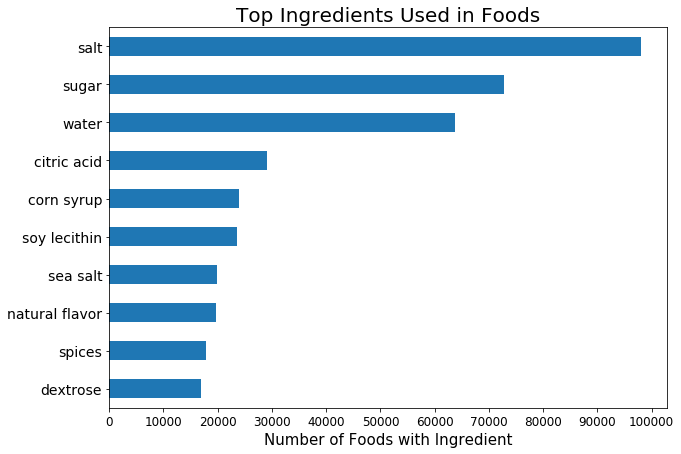

In [33]:
# building bar chart of top ingredients
plt.figure(figsize=(10, 7))

# sorting values, isolating top 10
ing_vec_df.sum().sort_values(ascending=True).tail(10).plot(kind="barh")

# setting visuals
plt.title("Top Ingredients Used in Foods", size=20)
plt.xlabel("Number of Foods with Ingredient", size=15)
plt.xticks(range(0, 100_001, 10_000), size=12)
plt.yticks(size=14);

This is a very interesting chart, showing that salt and sugar are the top two ingredients used in food products. With around 100,000 products containing salt, this accounts for more than half of our dataset of just under 190,000 food products, and that is not even including the additional entries of "sea salt".  While it may be tempting make connections between this list and much of the negative attention that processed foods have been getting in recent years, that is very much outside the scope of this project, and commentary will be limited to finding connections between ingredients and serving size.

Salt is a very versatile ingredient, being used in most types of foods, for everything from flavor to preservation<sup>2</sup>, so it is not surprising that it is the most common ingredient. The same can be said for sugar and corn syrup, which are used for more than just making foods sweeter, but can be effective ingredients for managing the texture and stability of foods<sup>3</sup>. Citric acid is another useful ingredient that can affect flavor profiles and is a common preservative<sup>4</sup>. 

Overall, the top ingredients across this dataset appear to be very multifunctional. This actually may not tell us much about the serving size of the food in question, as they are so common that anything could have them, and this does not tell us about how much of these ingredients are in foods. As we saw above in the visualization section, over 80,000 of the foods in this dataset have between 0-5g of sugar per 100g. However, the overall profile of a specific food may be able to create a more telling trend, meaning this could still be a very useful feature to have in our modeling process.

## Sources

1. https://fortune.com/global500/2019/
2. https://www.sciencedirect.com/science/article/pii/B9781845690182500088
3. https://www.ncbi.nlm.nih.gov/pubmed/3863796
4. https://www.sciencedaily.com/terms/citric_acid.htm